# ConvLSTM for forecasting

- without uncertainty

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import os, sys
import pandas as pd

- import **deephydro module** with networks, losses and metrics

In [2]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('../src')
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

# Data import

- paths

In [3]:
#os.chdir("/Users/schmidle/Documents/GIT-Projects/DeepHydro")
data_folder = '/data/debacwa/DeepHydro'
data_prec = '01_prec.nc'
data_temp = '01_temp.nc'
data_disc = '01_discharge.csv'

- read output data

In [4]:
def read_output_data(data_folder:str, data_disc:str):
    # read csv file
    df = pd.read_csv(os.path.join(data_folder, data_disc))
    # calculate fractional day of year
    df['DOY'] = pd.DatetimeIndex(df['Time']).dayofyear / 365
    return df

In [5]:
df = read_output_data(data_folder, data_disc)
df.head()

Unnamed: 0        Time      Q       DOY
0       27455  1950-01-01  558.0  0.002740
1       27456  1950-01-02  547.0  0.005479
2       27457  1950-01-03  541.0  0.008219
3       27458  1950-01-04  541.0  0.010959
4       27459  1950-01-05  564.0  0.013699

In [6]:
def plot_streamflow(df, n_labels=10):
    fig, ax = plt.subplots()
    ax.plot(df['Time'], df['Q'])
    ax.xaxis.set_major_locator(plt.MaxNLocator(n_labels)) # limit number of dates on x axis
    fig.autofmt_xdate() # rotate data labels
    plt.show()

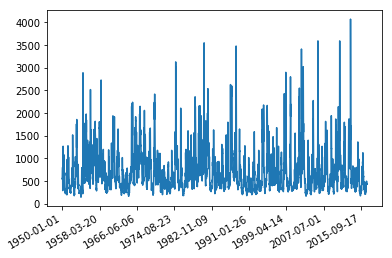

In [7]:
plot_streamflow(df)

- read input data (NetCDF4)

In [8]:
def read_data(filename, folder, varname):
    import netCDF4
    dat = netCDF4.Dataset(os.path.join(folder, filename))
    print(filename)
    arr = np.array(dat.variables[varname])
    mask = arr < 0
    arr[ mask ] = 0.0
    return arr, mask

def plot_frame(temp:np.array, prec:np.array, mask:np.array, df:pd.DataFrame, frame:int, limits:tuple=None):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    im_t = np.ma.masked_array(temp[frame], mask=mask[frame])
    im_p = np.ma.masked_array(prec[frame], mask=mask[frame])
    
    ax[0].set_title('Temperature')
    if limits is None:
        cb1 = ax[0].imshow(im_t)
    else:
        cb1 = ax[0].imshow(im_t, vmin=limits[0], vmax=limits[1])
    fig.colorbar(cb1, ax=ax[0], orientation='horizontal')

    ax[1].set_title('Precipitation')
    if limits is None:
        cb2 = ax[1].imshow(im_p)
    else:
        cb2 = ax[1].imshow(im_p, vmin=limits[2], vmax=limits[3])
    fig.colorbar(cb2, ax=ax[1], orientation='horizontal')
    
    for a in ax: a.axis('off')
        
    plt.show()


In [9]:
temp, mask = read_data(data_temp, data_folder, varname='z (unknown)')
prec, mask = read_data(data_prec, data_folder, varname='z (unknown)')

01_temp.nc
01_prec.nc


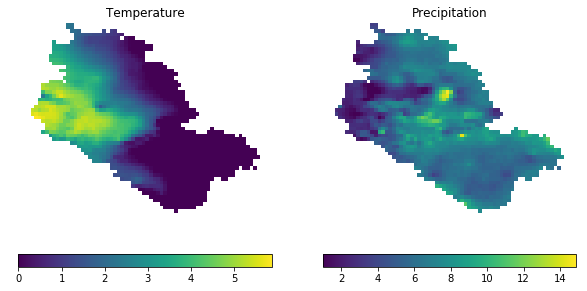

In [10]:
plot_frame(temp, prec, mask, df, frame=11)

# Data preparation

- standardize output data (`y`)

In [11]:
def standardize(data:np.array, return_moments=False):
    mean = np.mean(data)
    std = np.std(data)
    if return_moments:
        return (data-mean)/std, mean, std
    else:
        return (data-mean)/std

Shape of y =  (24472,)


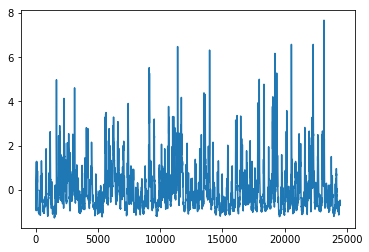

In [12]:
y, Y_MEAN, Y_STD = standardize(df['Q'].values, return_moments=True)
print('Shape of y = ', y.shape)

# plot data
plt.plot(y)

- standardize and combine input image (`x`)

Shape of x =  (24472, 53, 66, 2)


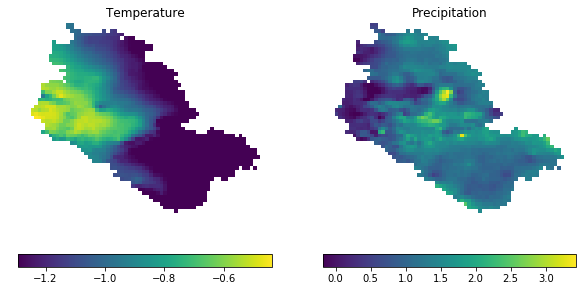

In [13]:
x_t = standardize(np.ma.masked_array(temp, mask=mask))
x_p = standardize(np.ma.masked_array(prec, mask=mask))
x = np.stack([x_t, x_p], axis=-1)
print('Shape of x = ', x.shape)

# plot sample frame
plot_frame(x_t, x_p, mask, df, frame=11)

In [14]:
x_doy = df['DOY'].values
print(x_doy)


[0.00273973 0.00547945 0.00821918 ... 0.99726027 1.         1.00273973]


- split train and test set
   - here: we don't use `train_test_split` anymore because we are dealing with sequences.
   - we simply take the first part as training data, and the last part as test data

In [15]:
# only use first 10% of data
x = x[:len(x)//5]
x_doy = x_doy[:len(x_doy)//5]
y = y[:len(y)//5]


In [16]:
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)

train_size = int(0.75 * len(x))
x_train, x_test, y_train, y_test = x[:train_size], x[train_size:], y[:train_size], y[train_size:]
x_train_doy, x_test_doy = x_doy[:train_size], x_doy[train_size:]

In [17]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_test  = ', x_test.shape)
print('Shape of y_test  = ', y_test.shape)


Shape of x_train =  (3670, 53, 66, 2)
Shape of y_train =  (3670,)
Shape of x_test  =  (1224, 53, 66, 2)
Shape of y_test  =  (1224,)


## Data generator

To sample image sequences, we do not store of all possible image sequences to memory. This would imply storing a lot of overlapping (=redundant) data.

Instead, we use a generator to generate a batch of random sequences. We could build a simple generator function using the `yield` statement, but to exploit parallel processing during batch generation, we will extend the `keras.utils.Sequence` class. 

In [18]:
# length of image sequence
n_frames = 30
# adjust this to available GPU memory (VRAM)
batch_size = 128

# use day of year ?
day_of_year = False
# forecasting ?
forecasting = False
# uncertainty estimation ?
uncertainty = False


In [19]:
# from deephydro.generator import ImageSequenceGenerator
# generator_train = ImageSequenceGenerator(data=x_train, labels=y_train, doy=x_train_doy,
#                                          batch_size=batch_size, n_frames=n_frames, 
#                                          day_of_year=day_of_year, forecasting=forecasting, uncertainty=uncertainty)
# generator_test  = ImageSequenceGenerator(data=x_test,  labels=y_test,  doy=x_test_doy,
#                                          batch_size=batch_size, n_frames=n_frames, 
#                                          day_of_year=day_of_year, forecasting=forecasting, uncertainty=uncertainty)

In [49]:
from deephydro.generator import ImageSequenceGenerator

n_frames = 30 # length of image sequence: how many days of data to predict streamflow?  
generator_train = ImageSequenceGenerator(data=x_train, labels=y_train, batch_size=batch_size, n_frames=n_frames)
generator_test  = ImageSequenceGenerator(data=x_train, labels=y_train, batch_size=batch_size, n_frames=n_frames)

In [50]:
batch = generator_train.__getitem__(0)
print(f'Shape of batch_x = {batch[0].shape}')
print(f'Shape of batch_y = {batch[1].shape}')


Shape of batch_x = (128, 30, 53, 66, 2)
Shape of batch_y = (128,)


In [51]:
#batch[0][0][1]

# Model

- load model
- predicts the streamflow from a short sequence of temperature and precipitation...

In [52]:
input_shape = (n_frames, *x_train.shape[1:])
from deephydro import networks
model = networks.nowcasting_model(input_shape, dayofyear=day_of_year)
#model = networks.get_conv_lstm_model(input_shape)
model.summary()

256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 30, 53, 66, 2)     0         
_________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)  (None, 30, 26, 32, 16)    10432     
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 26, 32, 16)    64        
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, 30, 12, 15, 32)    55424     
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 12, 15, 32)    128       
_________________________________________________________________
conv_lst_m2d_11 (ConvLSTM2D) (None, 30, 5, 7, 64)      221440    
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 5, 7, 64)      256       
______

- compile model: loss, optimizer and metrics

In [54]:
from keras import optimizers
from deephydro.losses import mse, logcosh, gauss
from deephydro.metrics import ccc

if uncertainty:
    loss=gauss
else:
    loss=logcosh
    
model.compile(optimizer=optimizers.Adam(lr=1e-3),
         loss=loss,
         metrics=[ccc])
             

# Training

In [55]:
n_epochs = 20

In [56]:
history = model.fit_generator(generator=generator_train,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=n_epochs,
                              validation_data=generator_test,
                              validation_steps=len(x_test)//batch_size,
                              use_multiprocessing=True,
                              workers=7,
                              max_queue_size=128)
                             

Epoch 1/20
12/28 [===========>..................] - ETA: 23s - loss: 0.3134 - ccc: 0.5823

Process ForkPoolWorker-161:
Process ForkPoolWorker-148:
Process ForkPoolWorker-150:
Process ForkPoolWorker-154:
Process ForkPoolWorker-152:
Process ForkPoolWorker-159:
Process ForkPoolWorker-153:
Process ForkPoolWorker-155:
Process ForkPoolWorker-149:
Traceback (most recent call last):
Process ForkPoolWorker-158:
Process ForkPoolWorker-156:
Process ForkPoolWorker-157:
Process ForkPoolWorker-151:
Traceback (most recent call last):
  File "/home/debacwa/miniconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/debacwa/miniconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Process ForkPoolWorker-160:
  File "/home/debacwa/miniconda3/envs/dl/lib/python3.6/mult

KeyboardInterrupt: 

In [ ]:
model.save('./model_nowcasting.h5')

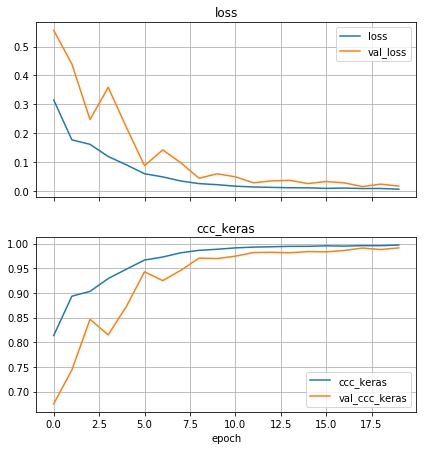

In [58]:
from deephydro.utils import plot_history
plot_history(history=history)

# Predict

In [41]:
def predict(model, image, gt=None, plot=False):
    
    im = image[np.newaxis, ...] # add batch dimension

    t = im[..., 0] # get temperature
    p = im[..., 1] # get precipitation

    y_pred = model.predict(im)[0,0] # get first element

    # calculate back to original units
    y_pred = Y_MEAN + y_pred * Y_STD

    if plot:
        limits = (t.min(), t.max(), p.min(), p.max())
        for frame in range(len(t[0])):
            print(f'Day {frame+1}')
            plot_frame(t[:,frame], p[:,frame], mask, df, 0, limits=limits)

    if gt is not None:
        y_true = Y_MEAN + gt * Y_STD
        if plot:
            print(f'Predicted streamflow = {y_pred:.1f}, ground truth = {y_true:.1f}')
        return y_pred, y_true
    else:
        print(f'Predicted streamflow = {y_pred:.1f}')
        return y_pred

In [42]:
random_test_sample = generator_test.__getitem__(0) # get single sample from batch
predict(model, random_test_sample[0][0], gt=random_test_sample[1][0], plot=False)

(452.3823056561508, 564.0)

## Evaluate prediction accuracy

- predict streamflow in multiple image sequences
- compare with ground truth streamflow
- using Lin's concordance correlation coefficient - basically Pearson correlation, corrected for bias


(128.74003974910565,
 1812.9107340081293,
 101.38482339955851,
 2006.6151766004414)

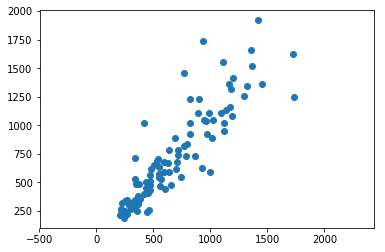

In [46]:
y_preds, y_trues = [], []
from tqdm import tqdm_notebook as tqdm
for _  in tqdm(range(100)):
    random_test_sample = generator_test.__getitem__(0) # get single sample from batch
    y_pred, y_true = predict(model, random_test_sample[0][0], gt=random_test_sample[1][0], plot=False)
    y_preds.append(y_pred)
    y_trues.append(y_true)

plt.scatter(y_preds, y_trues)
plt.axis('equal')


In [47]:
def ccc_numpy(y_true, y_pred):
    import numpy as np
    '''Lin's Concordance correlation coefficient: https://en.wikipedia.org/wiki/Concordance_correlation_coefficient'''
    
    # covariance between y_true and y_pred
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    s_xy = np.cov([y_true, y_pred], bias=True)[0,1] #[1,0] is the identical covariance between y_pred and y_true 
    # means
    x_m = np.mean(y_true)
    y_m = np.mean(y_pred)
    # variances
    s_x_sq = np.var(y_true)
    s_y_sq = np.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2)
    
    return ccc

In [48]:
print(f'Concordance correlation coefficient  = {ccc_numpy(y_trues, y_preds):.3f}')

Concordance correlation coefficient  = 0.872


# Saliency map

- using a variant of `DeepLIFT` called `DeepShap` based on Shapley values and implemented in the package [`shap`](https://github.com/slundberg/shap)


```
conda install -c conda-forge shap
pip install tqdm --upgrade # I needed to upgrade tqdm (progress bar)
```

In [ ]:
#from keras.models import load_model
#model = load_model('./model.h5')

In [ ]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
# return a list of tuples
background = np.mean(np.array([np.mean(generator_train.__getitem__(0)[0], axis=0) for _ in range(20)]), axis=0)
print(background.shape)
print(background[np.newaxis, ...].shape)

# explain predictions
e = shap.DeepExplainer(model, background[np.newaxis, ...])

test_sample = random_test_sample[0][0]
shap_values = e.shap_values(test_sample[np.newaxis, ...])

# plot the feature attributions
#shap.image_plot(shap_values, -test_sample[np.newaxis, 0, ..., 0])

In [ ]:
print(len(shap_values))
print(shap_values[0].shape)
print(shap_values[0][0].shape)

- plot saliency map

In [ ]:
fig, ax = plt.subplots(2, n_frames, figsize=(n_frames*4, 2*4)) 

for frame in range(len(shap_values[0][0])):
    
    ax[0,frame].set_title(f'Temp day {frame}')#'{-n_frames+frame+1}')
    vmin = np.min( shap_values[0][0])
    vmax = np.max( shap_values[0][0])

    vmin_t = np.min( shap_values[0][0, ..., 0])
    vmax_t = np.max( shap_values[0][0, ..., 0])
    im_t = np.ma.masked_array(shap_values[0][0, frame, ..., 0], mask=mask[frame])
    ax[0, frame].imshow(im_t, vmin=vmin, vmax=vmax)
    ax[0, frame].axis('off')
    
    ax[1, frame].set_title(f'Prec day {frame}')#'{-n_frames+frame+1}')
    vmin_p = np.min( shap_values[0][0, ..., 1])
    vmax_p = np.max( shap_values[0][0, ..., 1])
    im_p = np.ma.masked_array(shap_values[0][0, frame, ..., 1], mask=mask[frame])
    ax[1, frame].imshow(im_p, vmin=vmin, vmax=vmax)
    ax[1, frame].axis('off')
    
    
plt.show()